## Accessing LLMs via GROQ or Ollama

Large Language Models (LLMs) can be accessed through various platforms. Two great options are **GROQ** and **Ollama**, each suited for different needs.

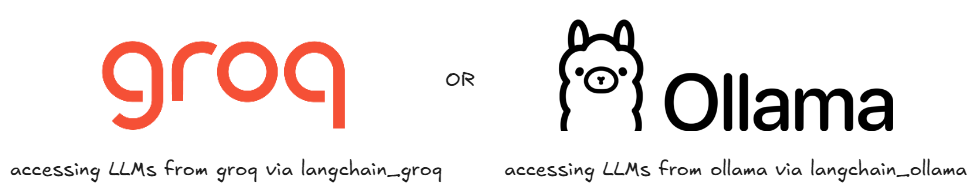

### GROQ
- **GROQ** is a free, cloud-based option ideal if you don't have an NVIDIA GPU or don't want to run models locally.
- It's optimized for high-speed AI inference, making it perfect for performance-driven applications.
- Use the `langchain_groq` package to integrate GROQ seamlessly into LangChain workflows.

### Ollama
- **Ollama** offers a developer-friendly, modern interface for hosting and interacting with LLMs.
- It simplifies model deployment and management, making it accessible to developers without extensive infrastructure setup.
- The `langchain_ollama` package enables easy integration with LangChain.

Both platforms allow you to interact with LLMs effortlessly while tailoring to your specific project requirements.


In [47]:
# some pip installs
!pip install langchain_community langchain_core
# If you don't have them installed yet, install them based on what you are using
!pip install langchain_groq
#%pip install langchain_ollama

In [48]:
from dotenv import load_dotenv
import os, getpass

# Load environment variables from the .env file
load_dotenv()

# Access the GROQ API key
var = "GROQ_API_KEY"
os.environ[var] = getpass.getpass(f"{var}: ")


GROQ_API_KEY:  ········


There are [a few standard parameters](https://python.langchain.com/v0.2/docs/concepts/#chat-models) that we can set with chat models. Two of the most common are:

* `model`: the name of the model
* `temperature`: the sampling temperature

`Temperature` controls the randomness or creativity of the model's output where low temperature (close to 0) is more deterministic and focused outputs. This is good for tasks requiring accuracy or factual responses. High temperature (close to 1) is good for creative tasks or generating varied responses. 

In [50]:
## Making an API Call to Groq/Ollama
# choose from a list of available models from the groq console / model playground
# for example, let's use llama-3.1-8b-instant here
from langchain_groq import ChatGroq
model = ChatGroq(model='llama-3.1-8b-instant', temperature=0.7)

Chat models in LangChain have a number of [default methods](https://python.langchain.com/v0.2/docs/concepts/#runnable-interface). For the most part, we'll be using:

* `stream`: stream back chunks of the response
* `invoke`: call the chain on an input

And, as mentioned, chat models take [messages](https://python.langchain.com/v0.2/docs/concepts/#messages) as input. Messages have a role (that describes who is saying the message) and a content property. We'll be talking a lot more about this later, but here let's just show the basics.

In [51]:
#model.invoke("hello world") if You want to get more detailed output 
message = model.invoke("hello world")

In [52]:
message.content # if you want only the output of the model

'Hello World. How can I assist you today?'

In [53]:
message.response_metadata['model_name'] # check the name of the model used

'llama-3.1-8b-instant'

In [54]:
message.response_metadata['token_usage'] # analyze how many tokens you consumed in this prompt

{'completion_tokens': 11,
 'prompt_tokens': 37,
 'total_tokens': 48,
 'completion_time': 0.014666667,
 'prompt_time': 0.003780003,
 'queue_time': 0.050961311,
 'total_time': 0.01844667}

In [55]:
# did your model stop generating due to token limit or some error, or did it complete generation successfully?
# to know this, we can use this property in the received message object
message.response_metadata['finish_reason']
# if it is 'stop', then there is no issue, else you most probably ran out of tokens or lost connection to the api

'stop'

In [56]:
message

AIMessage(content='Hello World. How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 37, 'total_tokens': 48, 'completion_time': 0.014666667, 'prompt_time': 0.003780003, 'queue_time': 0.050961311, 'total_time': 0.01844667}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_c5e685ab6f', 'finish_reason': 'stop', 'logprobs': None}, id='run-c8e9fabf-e888-4b31-9cc7-a4ed85bcfa91-0', usage_metadata={'input_tokens': 37, 'output_tokens': 11, 'total_tokens': 48})

We get an `AIMessage` response. Note that we can just invoke a chat model with a string like this. When a string is passed in as input, it is converted to a `HumanMessage` and then passed to the underlying model. If we want more control, we can use `langchain_core` package to provide more control such as chat history between AI and Human.

In [57]:
from langchain_core.messages import HumanMessage, AIMessage
import getpass
# Create a message history
msg1 = AIMessage(content="Hello who are you?", name="Bot")
msg2 = HumanMessage(content="Hello, my name is XYZ and I am interested in ABC", name="XYZ")
msg3 = AIMessage(content="Hi XYZ! How may I assist you?", name="Bot")
msg4 = HumanMessage(content="What's my name and what do I like?", name="XYZ")
# Message list
messages = [msg1, msg2, msg3, msg4]

# Invoke the model with a list of messages 
response = model.invoke(messages)
response

AIMessage(content="Your name is XYZ, but you didn't mention what you're interested in (ABC). You mentioned you're interested in ABC, but I don't have any information about what ABC represents. Can you tell me more about what ABC means to you?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 51, 'prompt_tokens': 86, 'total_tokens': 137, 'completion_time': 0.068, 'prompt_time': 0.006641515, 'queue_time': 0.017756325, 'total_time': 0.074641515}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_9cb648b966', 'finish_reason': 'stop', 'logprobs': None}, id='run-5eb3e8bf-c160-468e-9500-2ea67ba309b7-0', usage_metadata={'input_tokens': 86, 'output_tokens': 51, 'total_tokens': 137})

In [58]:
messages.append(response)
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hello who are you?
================================ Human Message =================================
Name: XYZ

Hello, my name is XYZ and I am interested in ABC
================================== Ai Message ==================================
Name: Bot

Hi XYZ! How may I assist you?
================================ Human Message =================================
Name: XYZ

What's my name and what do I like?
================================== Ai Message ==================================

Your name is XYZ, but you didn't mention what you're interested in (ABC). You mentioned you're interested in ABC, but I don't have any information about what ABC represents. Can you tell me more about what ABC means to you?


The interface is consistent across all chat models and models are typically initialized once at the start up each notebooks. 

So, you can easily switch between models without changing the downstream code if you have strong preference for another provider like ollama.


## Simple Memory Managemnt
 So far, we have seen a simple implementation of how you can get memory into your LLM application. But this is a pretty simple and inefficient solution as your project complexity increases. Nowadays with the rise of AI Agents, there have been significant changes to how Memo

## Memory in LangChain: Overview and Evolution

LangChain provides several ways to manage memory during conversations with LLMs. Memory is used to store and recall information throughout interactions, simulating context retention. Below are the primary types of memory that were available:

### Types of Memory offered before in Langchain which you can try to implement as excercises (they might be boring and straightforward tho)
1. **ConversationBufferMemory**  
   - Stores the complete history of the conversation in memory as a buffer.  
   - Useful for simple conversational agents that need to access the entire chat history.
2. **ConversationSummaryMemory**  
   - Summarizes the conversation as it progresses, instead of retaining the full history.  
   - Suitable for reducing memory usage in lengthy interactions.
3. **ConversationBufferWindowMemory**  
   - Maintains only the most recent `n` interactions in memory.  
   - Ideal for short-term context without excessive memory overhead.
4. **ConversationKGMemory**  
   - Builds a knowledge graph dynamically from the conversation to connect and infer relationships.  
   - Useful for applications requiring structured understanding of relationships between entities.
---

### Deprecation and Modern Approaches

These memory methods have been deprecated by LangChain as memory management in LLM applications has become more complex with advancements in AI agentic frameworks. New tools like **Pydantic**, **AutoGen**, and **LangGraph** enable richer and more flexible memory management tailored to dynamic AI agents. These frameworks emphasize robust, modular, and stateful interactions.
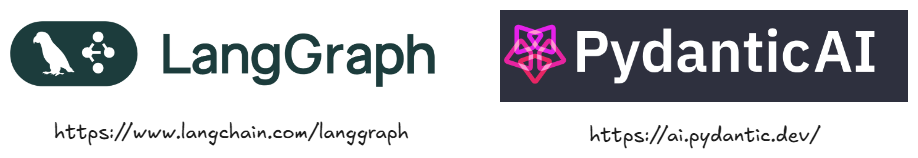  
To explore the updated capabilities and approaches in case of LangGraph, refer to the [LangChain Memory Documentation](https://python.langchain.com/api_reference/langchain/memory.html).

--- 

**Note**: As AI frameworks evolve, it is crucial to adapt memory strategies that align with your application’s complexity and requirements.


## JSON Mode Output in LLMs

When working with AI models, having them generate structured JSON outputs can be incredibly useful for practical applications. JSON mode output allows models to return data in a format that is easy to parse, integrate, and use programmatically.

### Why is JSON Output Useful?
1. **Structured Data**: JSON format ensures that the output is predictable and well-organized.
2. **Simplifies Integration**: JSON is widely supported and can be easily used with APIs, databases, or front-end interfaces.
3. **Efficient Data Handling**: JSON output eliminates the need for additional parsing or formatting logic, saving development time.

### Practical Use Cases
1. **Form Filling**:  
   - Automatically populate forms by extracting user-provided data into structured fields like name, email, and address.
   - Example: AI processes a conversation and outputs a JSON object that fills a customer feedback form.

2. **API Responses**:  
   - Generate API-ready responses from the model, seamlessly integrating with backend services.
   - Example: AI providing JSON responses to questions in a chatbot for integration with CRM systems.

3. **Data Parsing and Analysis**:  
   - Extract and structure data for analytics or reporting.
   - Example: Summarizing meeting notes into a JSON object with fields for agenda, attendees, and decisions.

### How does it work?
Very simple! Some models are fine-tuned to achieve the perfect JSON format. We can send a prompt to model in this way:
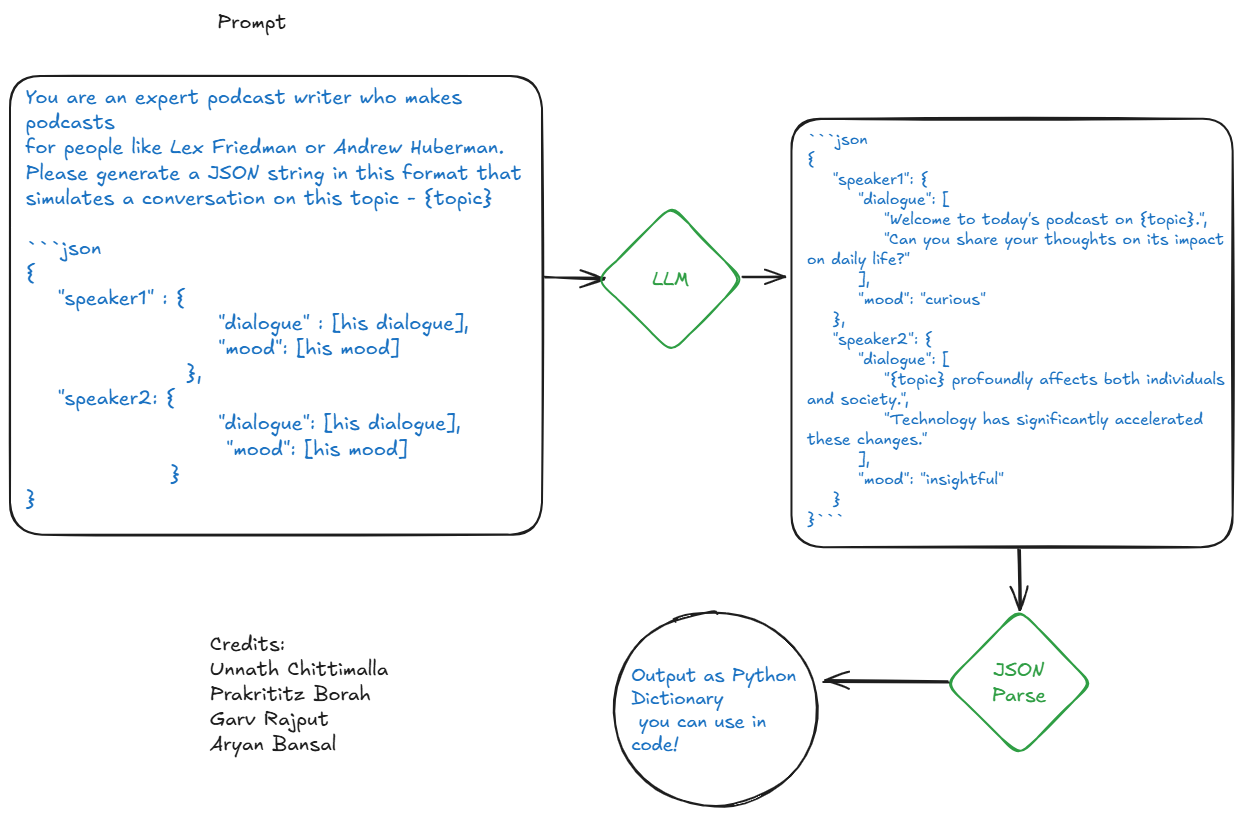

## Structured Output using Pydantic (more flexible than JSON)
It is build on top of the JSON ideology and has much more flexibility with the structure of data you want to generate.
If we want the model to return a Pydantic object, we just need to pass in the desired Pydantic class. The key advantage of using Pydantic is that the model-generated output will be validated. Pydantic will raise an error if any required fields are missing or if any fields are of the wrong type.

In [59]:
from typing import Optional

from pydantic import BaseModel, Field


# Pydantic
class Joke(BaseModel):
    """Joke to tell user."""

    setup: str = Field(description="The setup of the joke")
    punchline: str = Field(description="The punchline to the joke")
    rating: Optional[int] = Field(
        default=None, description="How funny the joke is, from 1 to 10"
    )


structured_model = model.with_structured_output(Joke)

response = structured_model.invoke("Tell me a joke about cats") # this returns a Joke object in python where you can access setup, punchline and rating via
response

Joke(setup='Why did the cat join a band?', punchline='Because it wanted to be the purr-cussionist', rating=8)

In [60]:
response.setup

'Why did the cat join a band?'

In [61]:
type(response.setup)

str

In [62]:
response.punchline

'Because it wanted to be the purr-cussionist'

In [63]:
type(response.punchline)

str

In [64]:
response.rating

8

In [65]:
type(response.rating)

int

## Tool Calling in Large Language Models (LLMs)

**Tool calling** enables LLMs to interact with external functions, APIs, or services during text generation. This capability allows models to perform tasks beyond their inherent knowledge base, significantly enhancing their practical utility.

### Benefits of Tool Calling
- **Dynamic Operations**: Perform tasks that require live or external data, such as database queries or real-time calculations.
- **Extended Capabilities**: Overcome limitations of static LLMs by integrating with APIs or tools for advanced functionality.
- **Automation**: Trigger external workflows, eliminating the need for manual intervention.

### Practical Applications
- **SQL Queries**: LLMs can interact with databases to fetch, update, or analyze data dynamically, enabling real-time insights.
- **Math Operations**: Perform complex calculations that were previously outside the model's capability.
- **Real-Time Updates**: Retrieve live data, such as current stock prices or weather information, to keep responses accurate and relevant.
- **Workflow Automation**: Trigger automated processes, such as scheduling tasks or sending notifications, directly through the model.

### Examples
1. **Querying a Database**:  
   Ask the model to retrieve specific information from a customer database, like the latest purchase records or user preferences.

2. **Performing Advanced Math**:  
   Use external tools to calculate compound interest, solve equations, or analyze statistical data.

3. **Real-Time Data Retrieval**:  
   Enable the model to fetch up-to-date weather forecasts, sports scores, or financial data.

4. **Document Summarization with API Support**:  
   Summarize lengthy documents by accessing and integrating with specialized summarization or translation APIs.

### Why Tool Calling Matters
Tool calling transforms LLMs from static models into dynamic problem-solvers, making them invaluable for applications requiring live data, external computations, or task automation.

For more details, check out the [LangChain Tool Calling Documentation](https://python.langchain.com/docs/concepts/tool_calling/).

By utilizing tool calling, developers can unlock new dimensions of functionality, bridging the gap between AI reasoning and real-world application needs.

## Demonstrating Tool Calling with LangChain

Tool calling allows an LLM to interact with external tools during a conversation. Here's a practical example demonstrating the use of simple math operations, such as addition and multiplication, through tool calling. Note that some smaller models may not support tool calling; in such cases, switch to larger models like the 70B variants for full functionality.
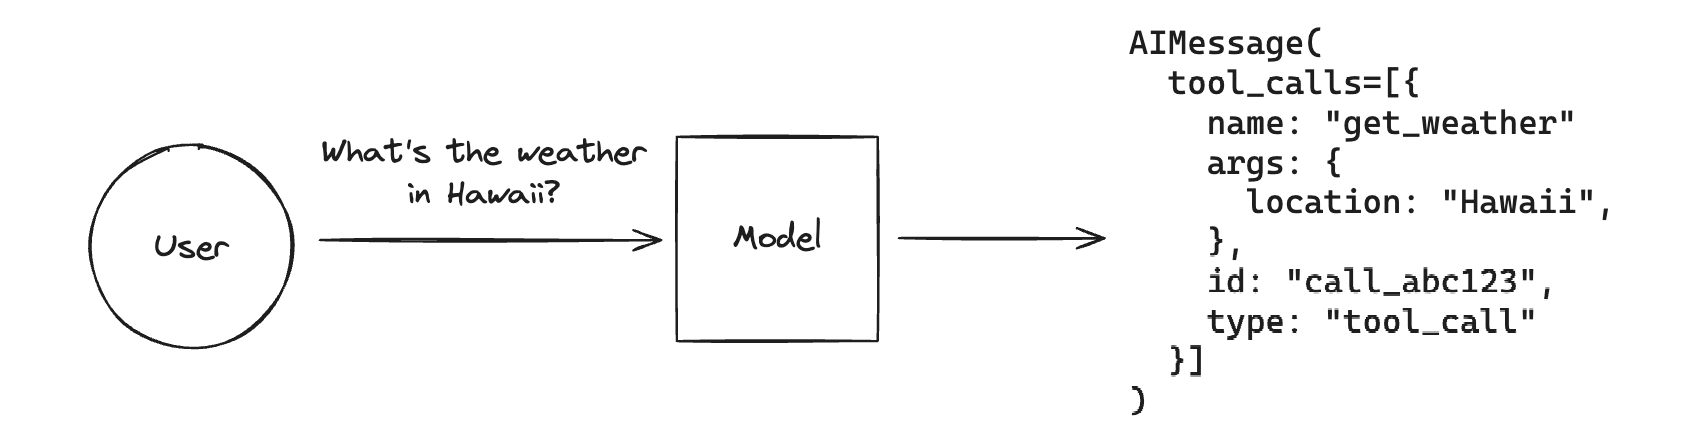
### Example: Simple Math Operations with Tool Calling

In [72]:
# The function name, type hints, and docstring are all part of the tool
# schema that's passed to the model. Defining good, descriptive schemas
# is an extension of prompt engineering and is an important part of
# getting models to perform well.
def add(a: int, b: int) -> int:
    """Add two integers.

    Args:
        a: First integer
        b: Second integer
    """
    return a + b


def multiply(a: int, b: int) -> int:
    """Multiply two integers.

    Args:
        a: First integer
        b: Second integer
    """
    return a * b

## LangChain Tool
LangChain also implements a @tool decorator that allows for further control of the tool schema, such as tool names and argument descriptions. See the how-to guide here for details.

In [73]:
from langchain_core.tools import tool


@tool
def add(a: int, b: int) -> int:
    """Adds a and b."""
    return a + b


@tool
def multiply(a: int, b: int) -> int:
    """Multiplies a and b."""
    return a * b


tools = [add, multiply]

model_with_tools = model.bind_tools(tools)

To actually bind those schemas to a chat model, we'll use the .bind_tools() method. This handles converting the add and multiply schemas to the proper format for the model. The tool schema will then be passed it in each time the model is invoked.

In [74]:
query = "what is 352 * 901, also what is 12312321+12387?"
messages = [HumanMessage(query)]
response_without_tools = model.invoke(messages)
response = model_with_tools.invoke(messages)
response

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_1nhr', 'function': {'arguments': '{"a": 352, "b": 901}', 'name': 'multiply'}, 'type': 'function'}, {'id': 'call_70cf', 'function': {'arguments': '{"a": 12312321, "b": 12387}', 'name': 'add'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 39, 'prompt_tokens': 288, 'total_tokens': 327, 'completion_time': 0.059554666, 'prompt_time': 0.027578835, 'queue_time': 0.018113725, 'total_time': 0.087133501}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f66ccb39ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-9436c27f-3017-47f9-9acb-5c737efaf1bd-0', tool_calls=[{'name': 'multiply', 'args': {'a': 352, 'b': 901}, 'id': 'call_1nhr', 'type': 'tool_call'}, {'name': 'add', 'args': {'a': 12312321, 'b': 12387}, 'id': 'call_70cf', 'type': 'tool_call'}], usage_metadata={'input_tokens': 288, 'output_tokens': 39, 'total_tokens': 327})

In [75]:
response_without_tools

AIMessage(content='To solve these problems:\n\n1. 352 * 901:\n   First, multiply 352 and 901.\n   352 * 900 = 316800\n   352 * 1 = 352\n   352 * 0 = 0\n   352 * 9 = 3168\n   Add all these together:\n   316800 + 352 = 317152\n   317152 + 3168 = 320320\n\nSo, 352 * 901 = 320320.\n\n2. 12312321 + 12387:\n   First, add the numbers:\n   12312321 + 12300 = 12324621\n   12324621 + 87 = 12324608\n\nSo, 12312321 + 12387 = 12324608.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 172, 'prompt_tokens': 54, 'total_tokens': 226, 'completion_time': 0.229333333, 'prompt_time': 0.004549799, 'queue_time': 0.018666071, 'total_time': 0.233883132}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_9cb648b966', 'finish_reason': 'stop', 'logprobs': None}, id='run-29d91cba-bda1-4eb2-8a6b-ba71963164ba-0', usage_metadata={'input_tokens': 54, 'output_tokens': 172, 'total_tokens': 226})

As we can see our LLM generated arguments to a tool! You can look at the docs for bind_tools() to learn about all the ways to customize how your LLM selects tools, as well as this guide on how to force the LLM to call a tool rather than letting it decide. We can check using .tool_calls if the model has used any tools while answering the query.

In [76]:
response.tool_calls

[{'name': 'multiply',
  'args': {'a': 352, 'b': 901},
  'id': 'call_1nhr',
  'type': 'tool_call'},
 {'name': 'add',
  'args': {'a': 12312321, 'b': 12387},
  'id': 'call_70cf',
  'type': 'tool_call'}]

In [77]:
messages.append(response)
for tool_call in response.tool_calls:
    selected_tool = {"add": add, "multiply": multiply}[tool_call["name"].lower()]
    tool_msg = selected_tool.invoke(tool_call)
    messages.append(tool_msg)

messages

[HumanMessage(content='what is 352 * 901, also what is 12312321+12387?', additional_kwargs={}, response_metadata={}),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_1nhr', 'function': {'arguments': '{"a": 352, "b": 901}', 'name': 'multiply'}, 'type': 'function'}, {'id': 'call_70cf', 'function': {'arguments': '{"a": 12312321, "b": 12387}', 'name': 'add'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 39, 'prompt_tokens': 288, 'total_tokens': 327, 'completion_time': 0.059554666, 'prompt_time': 0.027578835, 'queue_time': 0.018113725, 'total_time': 0.087133501}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f66ccb39ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-9436c27f-3017-47f9-9acb-5c737efaf1bd-0', tool_calls=[{'name': 'multiply', 'args': {'a': 352, 'b': 901}, 'id': 'call_1nhr', 'type': 'tool_call'}, {'name': 'add', 'args': {'a': 12312321, 'b': 12387}, 'id': 'call_70cf', 'type': 'tool_call'}], usag

In [78]:
model_with_tools.invoke(messages)

AIMessage(content='The result of 352 * 901 is 317152, and the result of 12312321 + 12387 is 12324708.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 32, 'prompt_tokens': 348, 'total_tokens': 380, 'completion_time': 0.049134811, 'prompt_time': 0.04078878, 'queue_time': 0.017843949000000005, 'total_time': 0.089923591}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f66ccb39ec', 'finish_reason': 'stop', 'logprobs': None}, id='run-c6400452-8c8a-4b1b-83ef-aadd6c1170c9-0', usage_metadata={'input_tokens': 348, 'output_tokens': 32, 'total_tokens': 380})

## An example of more prebuilt tools: Search Tools

We'll also take a small peek at [Tavily](https://tavily.com/), which is a search engine optimized for LLMs and RAG (Retrieval Augmented Generation), aimed at efficient, quick, and persistent search results. It has a generous free tier to use.

Tavily enables your LLM to access the web just like the WebSearch feature in ChatGPT. This ensures that if you query something about real world events or knowledge outside scope of the LLM you will always get consistent and right results depending on the quality of data it uses from the web.

Visit the website to get access to it's API key.

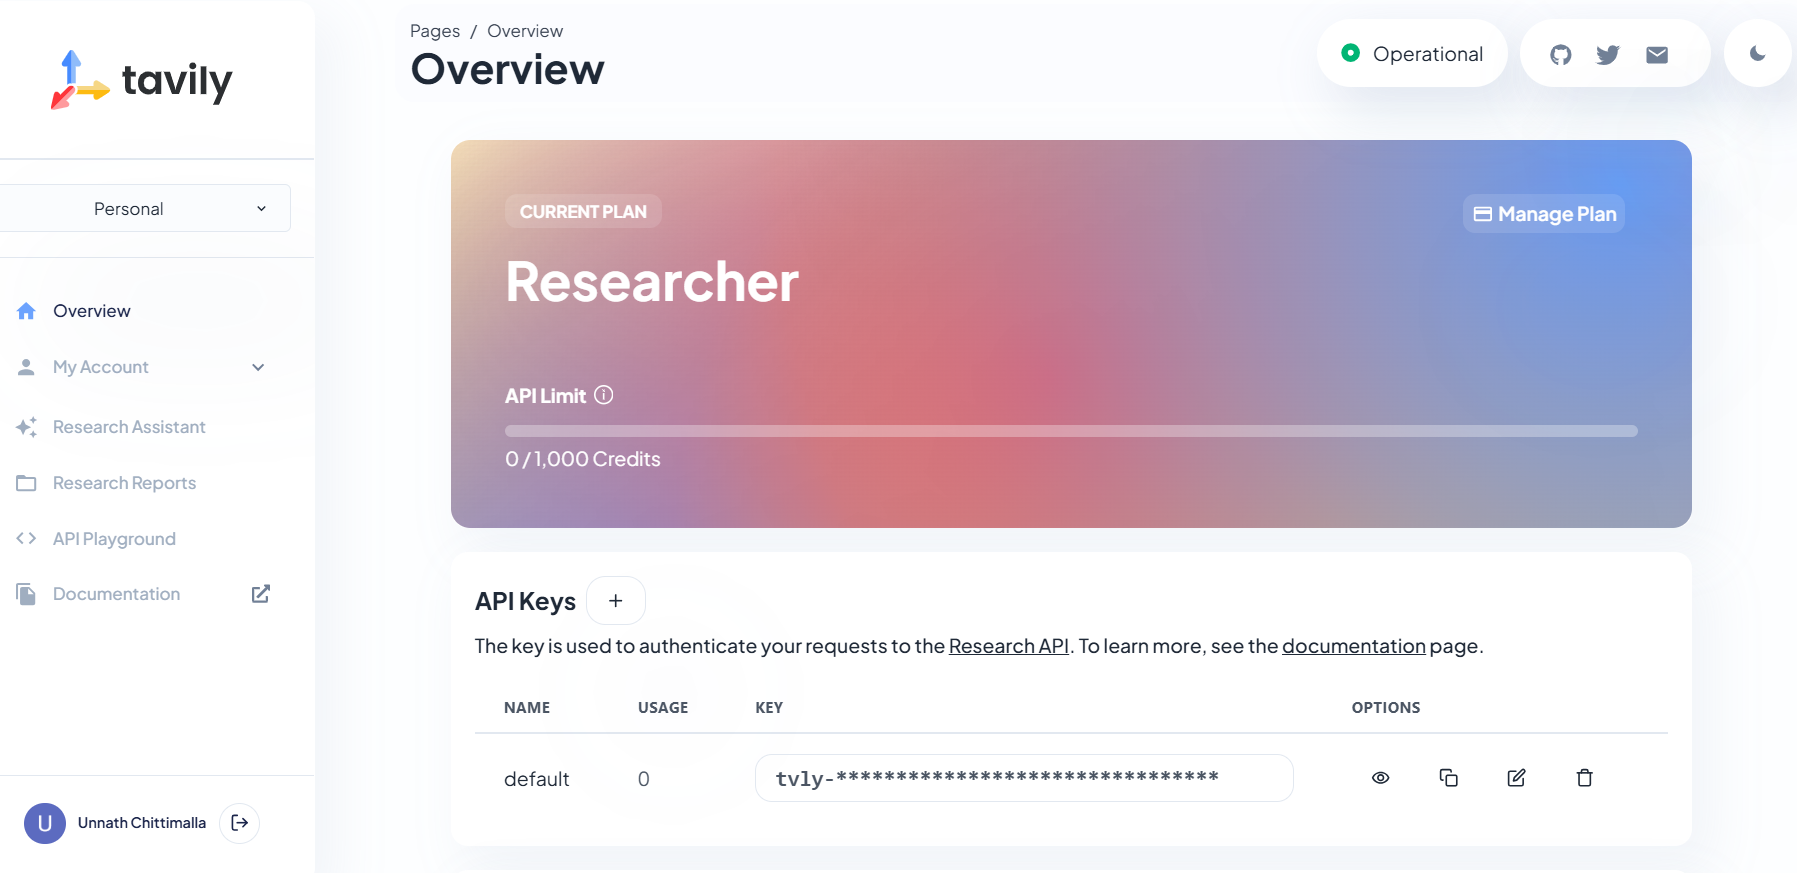

In [ ]:
import getpass
#paste in your tavily_api_key in the prompt after running this cell
var = "TAVILY_API_KEY"
os.environ[var] = getpass.getpass(f"{var}: ")

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search = TavilySearchResults(max_results=3)
search_docs = tavily_search.invoke("What are AI Agents?")

In [ ]:
search_docs